<a href="https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check Yo' Self 
**Self-serve checkout enhancement using Neural Networks and Deep Learning**

## Architecture
![alt text](https://github.com/MichaelCondo/Team9-APS360-Project/blob/main/docs/Architecture_Diagram.png?raw=true)

#### Colab Link
https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb

In [10]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Seed for reproducible results
np.random.seed(1000)
torch.manual_seed(1000)
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 1. Data Collection and Processing

**Tasks**:
* Understand Fruits 360 dataset
* Loading dataset into Colab
* Collecting prices of fruits
* Remove items that are not sold as individual fruits (i.e. vegetables, small berries, bunched bananas)
* Consolidate split classes either by combining or removing (e.g. Apple Red 1/2/3)
* Splitting the dataset into training, validation and testing (stratify or random) 

### 1.1 Fruits 360 Dataset

[Fruits 360](https://www.kaggle.com/moltean/fruits) is a dataset of 90000+ images of 130+ fruits and vegetables, in RGB colour at 100x100px a piece.

We're using [the GitHub mirror](https://github.com/Horea94/Fruit-Images-Dataset) to download the dataset as it does not require authentication to Kaggle.

In [2]:
# Download the dataset from GitHub
!wget -nc https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip \
    && mkdir -p "/root/project" \
    && unzip -nq "master.zip" -d "/root/project/datasets" \
    && find "/root/project/datasets/" -mindepth 2 -maxdepth 2 -type d -ls
DATA_MASTER_PATH = "/root/project/datasets/Fruit-Images-Dataset-master"

File ‘master.zip’ already there; not retrieving.

  3104831      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/papers
  3063810      4 drwxr-xr-x 133 root     root         4096 Nov 25 18:59 /root/project/datasets/Fruit-Images-Dataset-master/Training
  3104859      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/test-multiple_fruits
  3039292      4 drwxr-xr-x 133 root     root         4096 Nov 25 18:59 /root/project/datasets/Fruit-Images-Dataset-master/Test
  3104834      4 drwxr-xr-x   5 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/src


Let's take a look at the contents of the dataset. 

- How many training and testing samples do we have? 
- How many training samples are there for each of the classes?

In [3]:
!echo "Training samples" && find "{DATA_MASTER_PATH}/Training" -type f | wc -l 
!echo "Testing samples" && find "{DATA_MASTER_PATH}/Test" -type f | wc -l 

!echo "Training samples class distribution" \
    && cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

Training samples
67692
Testing samples
22688
Training samples class distribution
    984 ./Grape Blue
    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Strawberry Wedge
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    738 ./Cherry Rainier
    738 ./Cherry 2
    735 ./Walnut
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.2: Data Processing

Remove the folders that have items that are not sold individually, such as berries. Also, consolidate classes that feature the same type of fruit.

In [4]:
import requests

"""
This JSON (hosted on GitHub) contains a mapping from the original class names to
our new classes.

This will allow us to effectively consolidate classes that are similar looking
and would be treated similarly at a grocery store checkout.

We've also removed the classes that we don't want to train our model on such as
items that are not sold individually (e.g. small berries)
"""
CLASS_MAPPING = requests.get(
    "https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/original_to_new_class.json"
).json()

"""
This JSON (hosted on GitHub) contains the price per unit of our new classes.

The source is TODO

Also TODO: class prices for Quince and Salak are placeholders of -1
Also TODO: how/where to use this data?

Resources: 
* https://www.walmart.ca/en/grocery/fruits-vegetables/fruits/N-3852
* https://www.metro.ca/en/online-grocery/aisles/fruits-vegetables/fruits
* https://www.realcanadiansuperstore.ca/Food/Fruits-%26-Vegetables/c/RCSS001001000000
* https://www.fortinos.ca/Food/Fruits-%26-Vegetables/c/FTN001001000000 
* https://www.loblaws.ca/Food/Fruits-%26-Vegetables/c/LSL001001000000 
"""
CLASS_PRICES = requests.get(
    "https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/class_to_price.json"
).json()

In [5]:
import os
import shutil

for dataset_type in ["Training", "Test"]:
    for f in os.scandir(f"{DATA_MASTER_PATH}/{dataset_type}"):
        if f.is_dir() and f.name not in CLASS_MAPPING:
            shutil.rmtree(f.path)
            print("Removed", dataset_type, "/", f.name)

Removed Training / Grape White 3
Removed Training / Nut Forest
Removed Training / Grape White 4
Removed Training / Huckleberry
Removed Training / Mulberry
Removed Training / Grape Blue
Removed Training / Cherry 1
Removed Training / Strawberry
Removed Training / Cherry Wax Yellow
Removed Training / Raspberry
Removed Training / Redcurrant
Removed Training / Cherry Wax Red
Removed Training / Hazelnut
Removed Training / Grape White 2
Removed Training / Cherry Wax Black
Removed Training / Grape White
Removed Training / Strawberry Wedge
Removed Training / Cherry 2
Removed Training / Walnut
Removed Training / Blueberry
Removed Training / Nut Pecan
Removed Training / Chestnut
Removed Training / Grape Pink
Removed Training / Cherry Rainier
Removed Test / Grape White 3
Removed Test / Nut Forest
Removed Test / Grape White 4
Removed Test / Huckleberry
Removed Test / Mulberry
Removed Test / Grape Blue
Removed Test / Cherry 1
Removed Test / Strawberry
Removed Test / Cherry Wax Yellow
Removed Test / 

In [11]:
!cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    711 ./Pear Stone
    702 ./Pepper Orange
    702 ./Pear Forelle
    702 ./Fig
    702 ./Cauliflower
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.3: Data loading

Now we'll create Pytorch dataloaders for our train, validation, and test sets

In [12]:
class RemappedImageFolder(torchvision.datasets.ImageFolder):
    """Subclass of ImageFolder that lets you remap your classes at parse time
    instead of through target_transform (which would be applied on every getitem)
    """

    def __init__(self, class_remapping, **kwargs):
        self.class_remapping = class_remapping
        super(RemappedImageFolder, self).__init__(**kwargs)

    def _find_classes(self, dir):
        """Override ImageFolder's class identification method so we can
        do custom consolidation of our classes.
        See https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
        """
        # Get the original classes (i.e. folder names)
        o_classes = super()._find_classes(dir)[0]

        # Get our classes (from the JSON mapping)
        classes = list(sorted(set(self.class_remapping.values())))

        # Create an index for only our new classes
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Map the old classes to their indices in our new system
        real_class_to_idx = {
            old_class: new_class_to_idx[self.class_remapping[old_class]]
            for old_class in o_classes
        }

        return classes, real_class_to_idx

In [13]:
from sklearn.model_selection import train_test_split

def get_data_loaders(batch_size=1, num_workers=1):
    """Loads images of produce, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch (<1 means 
        use the full dataset in every batch)
    
    Returns:
        train_loader: iterable training dataset (from training data)
        val_loader: iterable validation dataset (from training data)
        test_loader: iterable testing dataset (from test data)
        classes: A list of strings denoting the name of each class
    """
    ########################################################################
    # We'll return a (train, val, test, classes) tuple
    classes = list(sorted(set(CLASS_MAPPING.values())))

    # Load datasets
    train_set, test_set = [
        RemappedImageFolder(
            class_remapping=CLASS_MAPPING,
            root=f"{DATA_MASTER_PATH}/{kind}",
            transform=transforms.Compose(
                [transforms.Resize((100, 100)), transforms.ToTensor()]
            ),
        )
        for kind in ("Training", "Test")
    ]

    # Split train/validation data with stratification of classes
    train_idx, val_idx = train_test_split(
        np.arange(len(train_set.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=train_set.targets
    )

    train_set, val_set = [
        torch.utils.data.Subset(train_set, idx)
        for idx in [train_idx, val_idx]
    ]

    # Create and return the data loaders
    bs = len(train_set) if batch_size < 1 else batch_size
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(val_set) if batch_size < 1 else batch_size
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(test_set) if batch_size < 1 else batch_size
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )

    return train_loader, val_loader, test_loader, classes

Found 38035 Training examples
Found 16301 Validation examples
Found 18215 Test examples
There are 91 classes
Training set looks like:


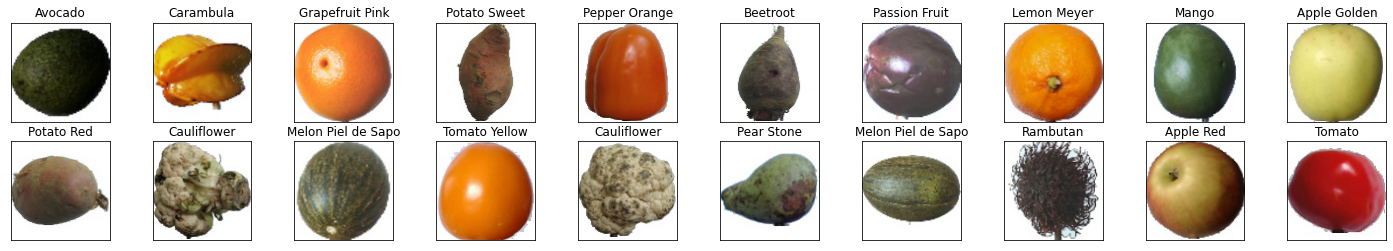

In [14]:
# Count the samples
for kind, loader in zip(["Training", "Validation", "Test"], get_data_loaders()[:3]):
    print(f"Found {len(loader)} {kind} examples")

# Prepare dataloaders for real
train_loader, val_loader, test_loader, classes = get_data_loaders(
    batch_size=27  # we know that this is a divisor of the number of submissions
)

print("There are", len(classes), "classes")

print("Training set looks like:")
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## 2. Baseline Model

**Tasks**:
* Setup and train random forrest model


In [15]:
train_images = []
train_labels = []
for inputs, labels in iter(train_loader):
  for image in inputs:
    #Resize image from (100, 100) to (45, 45)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(45,45), mode='bilinear')
    image = image.squeeze(0)

    #Transform Tensor from [3, 45, 45] to a numpy array of shape (45, 45, 3)
    image = image.permute(1, 2, 0).numpy()
    train_images.append(image)

  for label in labels:
    train_labels.append(label)

print(len(train_images))
print(len(train_labels))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


38035
38035


In [16]:
print(train_images[0].shape)

(45, 45, 3)


In [17]:
test_images = []
test_labels = []
for inputs, labels in iter(get_data_loaders(-1)[2]):
  for image in inputs:
    #Resize image from (100, 100) to (45, 45)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(45,45), mode='bilinear')
    image = image.squeeze(0)

    #Transform Tensor from [3, 45, 45] to a numpy array of shape (45, 45, 3)
    image = image.permute(1, 2, 0).numpy()
    test_images.append(image)

  for label in labels:
    test_labels.append(label)
    
print(len(test_images))
print(len(test_labels))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


18215
18215


In [18]:
print(test_images[0].shape)
print(test_labels[0])

(45, 45, 3)
tensor(29)


In [19]:
train_images = np.array(train_images)
print(train_images.shape)

# 38035 is the number of samples, 6075 is 45*45*3
train_pixels = train_images.flatten().reshape(38035, 6075)
print(train_pixels.shape)

train_labels = np.array(train_labels)
print(train_labels.shape)

(38035, 45, 45, 3)
(38035, 6075)
(38035,)


In [20]:
test_images = np.array(test_images)
print(test_images.shape)

# 18215 is the number of samples, 6075 is 45*45*3
test_pixels = test_images.flatten().reshape(18215, 6075)
print(test_pixels.shape)

test_labels = np.array(test_labels)
print(test_labels.shape)

(18215, 45, 45, 3)
(18215, 6075)
(18215,)


In [21]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250)

# Fit the model to our training data
model.fit(train_pixels, train_labels)

#Make predictions
testing_predicted = model.predict(test_pixels)

In [22]:
correct = 0
for i in range(len(testing_predicted)):
  if testing_predicted[i] == test_labels[i]:
    correct += 1

score = 100* (correct / len(testing_predicted))

print("RF Test:", score)

RF Test: 94.3178698874554


## 3. Model Setup

**Tasks**:
* Using previous labs as reference, create CNN skeleton to work for 100x100 RGB images


In [ ]:
class CNN(nn.Module):
    """
    A simple CNN classifier that takes a list of output classes on init
    to determine the output layer size. Assumes an input of size nx3x100x100.
    """
    def __init__(self, output_classes):
        super(CNN, self).__init__()
        num_outputs = len(output_classes)
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 6, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 12, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(12 * 6 * 6, 250),
            nn.ReLU(),
            nn.Linear(250, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 12 * 6 * 6)
        x = self.classifier(x)
        return x

In [ ]:
model = CNN(classes)
# See if dimensions are okay
model(torch.randn((64, 3, 100, 100)))

# See model stats
print(model.__class__.__name__, "parameters:", sum(p.numel() for p in model.parameters()))
print(model)

CNN parameters: 132045
CNN(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(6, 6), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=432, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=91, bias=True)
  )
)


## 4. Model Training and Tuning

**Tasks**:
* Write training code 
* Adjust hyperparameters to get at least 90% validation accuracy
* Evaluate model on the test set to see true performance



In [ ]:
def get_model_name(model, batch_size=1, learning_rate=1e-3, iteration=0):
    """Generate a name for the model with the hyperparameter values"""
    return "model_{0}_bs{1}_lr{2}_checkpoint{3}".format(
        model.__class__.__name__, batch_size, learning_rate, iteration
    )


def evaluate(model, data_loader, criterion=None):
    """Evaluate the model (accuracy, loss) on the given dataset
    If critierion is not provided, only accuracy will be computed.
    """
    correct, total = 0, 0
    total_loss = 0.0
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Calculate batch
        outputs = model(inputs)

        # Correctness: select index with maximum prediction score
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += pred.shape[0]

        # Optional loss computation
        if criterion:
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    if criterion:
        return correct / total, total_loss / len(data_loader)
    else:
        return correct / total


def plot_training_curve(path):
    """ Plots accuracy/loss curves for a model run given the CSV path"""
    import matplotlib.pyplot as plt

    iterations, train_acc, val_acc, train_loss, val_loss = np.loadtxt(
        f"{model_path}_training.csv"
    ).T

    plt.title("Train vs Validation Accuracy")
    plt.plot(iterations, train_acc, label="Train")
    plt.plot(iterations, val_acc, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(iterations, train_loss, label="Train")
    plt.plot(iterations, val_loss, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    print(
        "Best Training Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(train_acc) * 100, iterations[np.argmax(train_acc)]
        )
    )
    print(
        "Best Validation Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(val_acc) * 100, iterations[np.argmax(val_acc)]
        )
    )

In [ ]:
def train(model, batch_size=1, num_epochs=1, learning_rate=1e-3, plot_frequency=1):
    train_loader, val_loader, test_loader, classes = get_data_loaders(
        batch_size=batch_size
    )

    # Statistic collection
    PLOT_ITERATIONS = int(-(-len(train_loader) // plot_frequency))  # ceil division
    iterations, train_acc, val_acc, train_loss, val_loss = [], [], [], [], []

    def collect_stats(epoch, iteration, t_loss=None):
        # Don't double count
        if iterations and iterations[-1] >= iteration:
            return
        # Compute and store
        if t_loss is None:
            t_acc, t_loss = evaluate(model, train_loader, criterion)
        else:
            t_acc = evaluate(model, train_loader)

        v_acc, v_loss = evaluate(model, val_loader, criterion)

        iterations.append(iteration)
        train_acc.append(t_acc)
        val_acc.append(v_acc)
        train_loss.append(t_loss)
        val_loss.append(v_loss)

        # Checkpoint model
        model_path = get_model_name(model, batch_size, learning_rate, iteration)
        torch.save(model.state_dict(), model_path)

        # Print stats
        print(
            f"@{time.time()-start_time : .2f}s",
            f"Epoch {epoch} Iteration {iteration}:",
            f"Train acc: {t_acc * 100 : .2f}%",
            f"Train loss: {t_loss : .4f}",
            "|",
            f"Validation acc: {v_acc * 100 : .2f}%",
            f"Validation loss: {v_loss : .4f}",
        )

    # Training loop
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the network
    print("Training Started...")
    start_time = time.time()
    iteration = 0
    for epoch in range(num_epochs):
        for inputs, labels in iter(train_loader):
            # Place on correct device if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass, backward pass, optimize, and clean up
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Compute training metrics
            iteration += 1
            if iteration % PLOT_ITERATIONS == 0:
                collect_stats(epoch, iteration, loss.item())

    # Final stats (runs only if previous iteration wasn't saved)
    collect_stats(epoch, iteration, loss.item())

    print(f"Finished Training -- Total time elapsed: {time.time()-start_time : .2f}s")
    model_path = get_model_name(model, batch_size, learning_rate, iteration)
    np.savetxt(
        f"{model_path}_training.csv",
        np.c_[iterations, train_acc, val_acc, train_loss, val_loss],
    )
    return model_path

Training Started...
@ 78.53s Epoch 0 Iteration 1409: Train acc:  91.73% Train loss:  0.1489 | Validation acc:  91.35% Validation loss:  0.2775
@ 141.64s Epoch 1 Iteration 2818: Train acc:  96.25% Train loss:  0.0163 | Validation acc:  96.01% Validation loss:  0.1161
@ 204.23s Epoch 2 Iteration 4227: Train acc:  99.28% Train loss:  0.0052 | Validation acc:  99.22% Validation loss:  0.0285
@ 266.84s Epoch 3 Iteration 5636: Train acc:  98.99% Train loss:  0.1142 | Validation acc:  98.71% Validation loss:  0.0432
@ 329.41s Epoch 4 Iteration 7045: Train acc:  98.97% Train loss:  0.0054 | Validation acc:  98.86% Validation loss:  0.0344
Finished Training -- Total time elapsed:  329.45s
Model available at: model_CNN_bs27_lr0.001_checkpoint7045


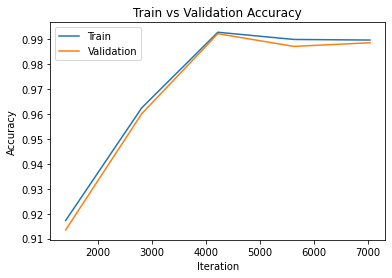

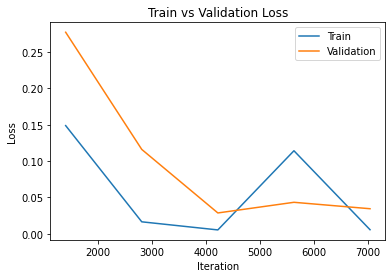

Best Training Accuracy: 99.28% @ checkpoint 4227
Best Validation Accuracy: 99.22% @ checkpoint 4227


In [ ]:
model = CNN(classes)
if torch.cuda.is_available():
    model.cuda()

model_path = train(
    model,
    batch_size=27,
    num_epochs=5,
    learning_rate=1e-3,
    plot_frequency=1,
)
print("Model available at:", model_path)
plot_training_curve(model_path)

In [ ]:
model = CNN(classes)

model.load_state_dict(torch.load(get_model_name(model, 27, 1e-3, 4227)))
if torch.cuda.is_available():
    model.cuda()

test_acc = evaluate(model, get_data_loaders(-1)[2])
print("Testing Accuracy: {:.2f}%".format(test_acc * 100))

Testing Accuracy: 90.37%


Test set verification:


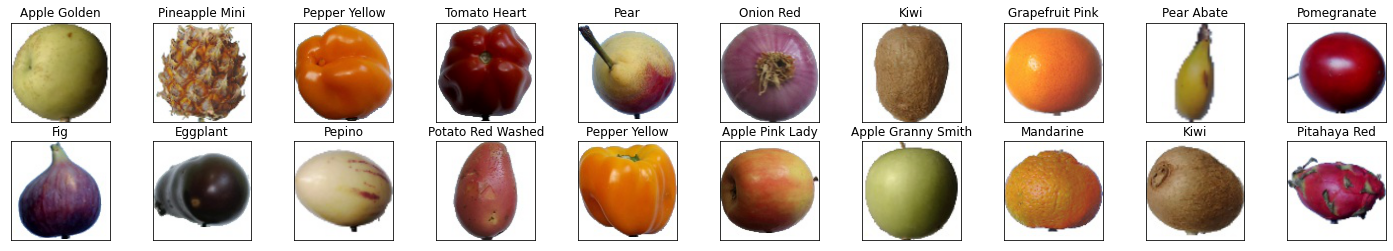

In [ ]:
print("Test set verification:")

# Obtain one batch of test images
dataiter = iter(get_data_loaders(-1, 0)[2])
images, labels = dataiter.next()
out = model(images.cuda())
pred = out.max(1, keepdim=True)[1]
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[pred[idx]])

In [ ]:
"""
  Here we can visually verify a batch of images from the test set classified 
  by the model
"""